In [44]:
# Required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from dotenv import load_dotenv
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [45]:
FILE_NAME = 'feature_frame.csv'
S3_DIR = 'groceries/box_builder_dataset/'
BUCKET_NAME = 'zrive-ds-data'
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = 'data/'
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME

def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    
    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return
    
    try:
        s3 = boto3.client('s3',
                         aws_access_key_id=AWS_ACCESS_KEY_ID,
                         aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
        
        key = S3_DIR + FILE_NAME
        
        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")
        
    except Exception as e:
        print(f"Error downloading file: {e}")
        raise

# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)


File already exists at data/feature_frame.csv


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [47]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [48]:
df['outcome'].value_counts(normalize=True)

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64

In [49]:
df['days_since_purchase_product_type'].value_counts()

days_since_purchase_product_type
30.0     2284388
14.0       16494
21.0       14917
29.0       14904
20.0       14037
          ...   
148.0        116
134.0        100
117.0         58
128.0         58
145.0         44
Name: count, Length: 141, dtype: int64

## Filtering Data

Only those purchases with more than 5 products bought

In [50]:
# Paso 1: Agrupar por order_id y contar los productos con outcome=1
items_comprados_por_orden = df[df['outcome'] == 1.0].groupby('order_id').size()

# Paso 2: Crear un DataFrame con esta información
items_comprados_df = items_comprados_por_orden.reset_index(name='items_comprados')

# Paso 3: Hacer un merge con el DataFrame original
df = df.merge(items_comprados_df, on='order_id', how='left')

# Para órdenes que no tienen ningún producto comprado, reemplazar NaN con 0
df['items_comprados'] = df['items_comprados'].fillna(0).astype(int)

In [51]:
valuable_orders_df = df[df['items_comprados'] > 5]
valuable_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2023050 entries, 0 to 2880547
Data columns (total 28 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      float64

## Building linear model

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    precision_recall_curve,
    average_precision_score, 
    roc_auc_score,
    f1_score
)
from datetime import datetime
import re
import sys

random_state = 42

### Data Split

In [60]:
target_col = 'outcome'
x_drop_cols = ['outcome', 'order_id', 'user_id', 'variant_id', 'items_comprados', 'created_at']

def split_data(
        df: pd.DataFrame, target_col: str, order_id_column='order_id',
        train_size: int = 0.7, val_size: int = 0.2, 
        random_state:int=42
    ) -> tuple:

    X = valuable_orders_df
    y = valuable_orders_df[target_col]

    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(X, y, groups=df[order_id_column]))

    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()

    X_temp = X.iloc[temp_idx].copy()
    y_temp = y.iloc[temp_idx].copy()
    groups_temp = df.iloc[temp_idx][order_id_column].copy()

    remaining_proportion = 1 - train_size
    val_proportion_of_remaining = val_size / remaining_proportion

    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_proportion_of_remaining, random_state=random_state)
    val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=groups_temp))

    X_val = X_temp.iloc[val_idx].copy()
    y_val = y_temp.iloc[val_idx].copy()
    
    X_test = X_temp.iloc[test_idx].copy()
    y_test = y_temp.iloc[test_idx].copy()

    train_orders = set(X_train[order_id_column].unique())
    val_orders = set(X_val[order_id_column].unique())
    test_orders = set(X_test[order_id_column].unique())

    columns_to_drop = ['outcome', 'order_id', 'user_id', 'variant_id', 'created_at']
    X_train.drop(columns=columns_to_drop, inplace=True)
    X_val.drop(columns=columns_to_drop, inplace=True)
    X_test.drop(columns=columns_to_drop, inplace=True)

    assert len(train_orders.intersection(val_orders)) == 0, "There are duplicate orders between train and val"
    assert len(train_orders.intersection(test_orders)) == 0, "There are duplicate orders between train and test"
    assert len(val_orders.intersection(test_orders)) == 0, "There are duplicate orders between val and test"

    print(f"Split completed:")
    print(f"  Train: {len(X_train)} rows, {len(train_orders)} unique orders")
    print(f"  Val:   {len(X_val)} rows, {len(val_orders)} unique orderss")
    print(f"  Test:  {len(X_test)} rows, {len(test_orders)} unique orders")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(valuable_orders_df, target_col, random_state=random_state)

Split completed:
  Train: 1418838 rows, 1703 unique orders
  Val:   403282 rows, 486 unique orderss
  Test:  200930 rows, 244 unique orders


### Data preprocessing

In [61]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_column='order_date', drop_original=True):
        self.date_column = date_column
        self.drop_original = drop_original
        
    def process_date(self, input_str):
        date_str = input_str.split(' ')[0]
        
        # Validate date string input
        regex = re.compile(r'\d{4}-\d{2}-\d{2}')
        if not re.match(regex, date_str):
            return {}  # Manejar error silenciosamente o registrar
        
        # Process date features
        my_date = datetime.strptime(date_str, '%Y-%m-%d').date()
        date_feats = {}
        
        date_feats['year'] = int(my_date.strftime('%Y'))
        date_feats['month_num'] = int(my_date.strftime('%m'))
        date_feats['dom'] = int(my_date.strftime('%d'))
        date_feats['doy'] = int(my_date.strftime('%j'))
        date_feats['woy'] = int(my_date.strftime('%W'))
        
        # Fixing day of week to start on Mon (1), end on Sun (7)
        dow = my_date.strftime('%w')
        if dow == '0': dow = 7
        date_feats['dow_num'] = int(dow)
        
        date_feats['is_weekend'] = 1 if int(dow) > 5 else 0
        
        return date_feats
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        date_features = []
        for date_value in X_copy[self.date_column]:
            date_features.append(self.process_date(date_value))
        
        date_df = pd.DataFrame(date_features, index=X_copy.index)
        
        X_transformed = pd.concat([X_copy, date_df], axis=1)
        
        if self.drop_original and self.date_column in X_transformed.columns:
            X_transformed = X_transformed.drop(columns=[self.date_column])
            
        return X_transformed


# 2. Transformador para encodificación de frecuencia
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.frequency_maps = {}
        
    def fit(self, X, y=None):
        for column in self.categorical_columns:
            if column in X.columns:
                frequencies = X[column].value_counts(normalize=True).to_dict()
                self.frequency_maps[column] = frequencies
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                # Para valores no vistos en entrenamiento, asigna la frecuencia más baja
                default_value = min(self.frequency_maps[column].values()) if self.frequency_maps[column] else 0
                
                # Transforma aplicando el mapeo, con un valor predeterminado para categorías nuevas
                X_copy[column] = X_copy[column].map(lambda x: self.frequency_maps[column].get(x, default_value))
                
        return X_copy


def create_preprocessing_pipeline() -> Pipeline:
    categorical_columns = ['product_type', 'vendor']
    date_column = 'order_date'
    
    preprocessing_pipeline = Pipeline([
        
        ('date_transformer', DateFeatureTransformer(
            date_column=date_column, 
            drop_original=True
        )),
        
        ('frequency_encoder', FrequencyEncoder(
            categorical_columns=categorical_columns
        )),
        
        ('scaler', StandardScaler())
    ])
    
    return preprocessing_pipeline

### Model Fitting

In [62]:
print(f"Features: {X_train.columns.tolist()}")

Features: ['product_type', 'order_date', 'user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct', 'vendor', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type', 'items_comprados']


In [75]:
full_pipeline = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty=None, 
            class_weight=None, 
            max_iter=1000, 
            random_state=random_state
        ))
])

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date_transformer', DateFeatureTransformer()),
                                 ('frequency_encoder',
                                  FrequencyEncoder(categorical_columns=['product_type',
                                                                        'vendor'])),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 LogisticRegression(max_iter=1000, penalty=None,
                                    random_state=42))])

Evaluate a classification model. Get the metrics

In [79]:
def evaluate_classification_model(
        y_true, y_pred, figsize=(20, 15), 
        title_prefix="", save_fig=False, filename=None
    ) -> dict:
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1 Score': f1_score(y_true, y_pred),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }
    
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{title_prefix}Confusion Matrix', fontsize=14)
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['0', '1'])
    plt.yticks([0.5, 1.5], ['0', '1'])
    
    plt.subplot(2, 3, 2)
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
    
    values = [metrics[m] for m in metrics_to_plot]
    bars = plt.barh(metrics_to_plot, values, color='steelblue')
    plt.xlim(0, 1)
    plt.title(f'{title_prefix}Metrics', fontsize=14)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width:.4f}', va='center')
    
    
    
    plt.subplot(2, 3, 5)
    plt.axis('off')
    metrics_cell_text = [[key, f"{value:.4f}" if isinstance(value, float) else value] 
                         for key, value in metrics.items()]
    plt.table(cellText=metrics_cell_text, colLabels=['Metric', 'Value'], 
              loc='center', cellLoc='center')
    plt.title(f'{title_prefix}Metrics Table', fontsize=14)
    
    plt.tight_layout()
    
    if save_fig:
        if filename is None:
            filename = f"{title_prefix.strip()}_model_evaluation.png" if title_prefix else "model_evaluation.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"\n{title_prefix}Clasification report:")
    print(classification_report(y_true, y_pred))
    
    return metrics

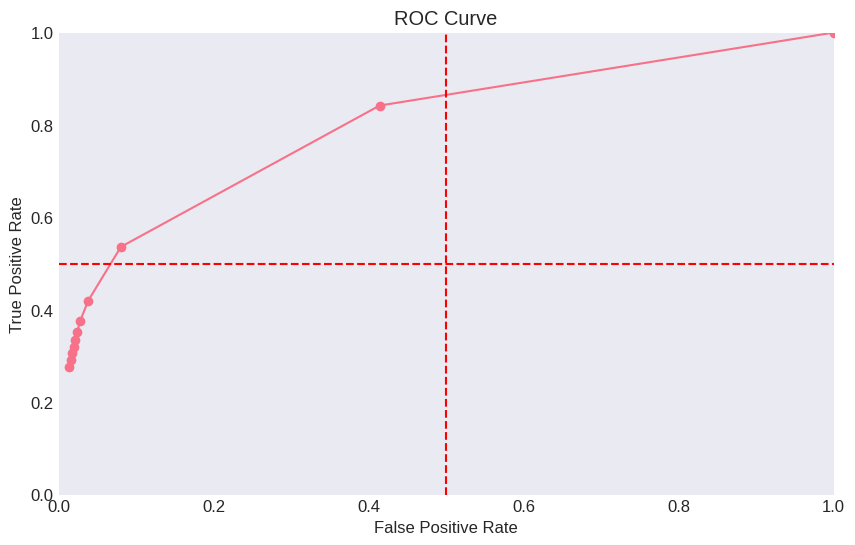

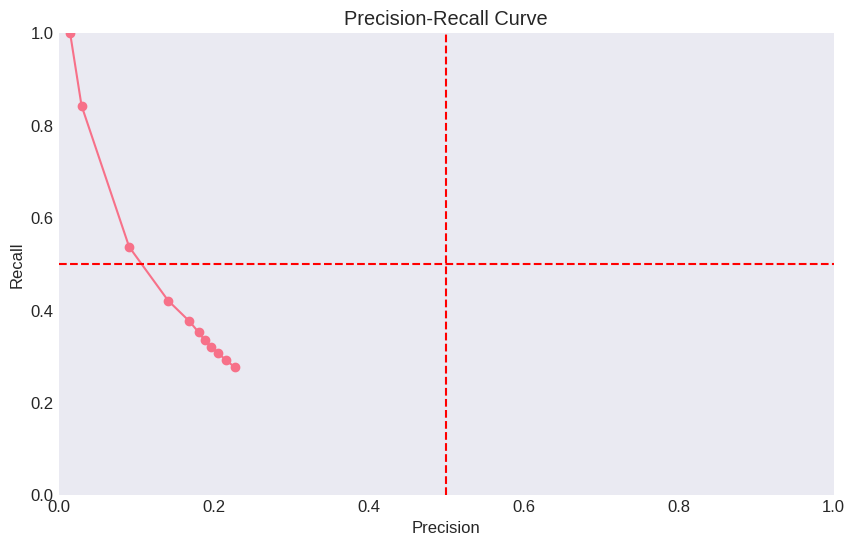

In [99]:
y_val_proba = full_pipeline.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 0.11, 0.01)
true_positive_rates = []
false_positive_rates = []
precisions = []
for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    true_positive_rates.append(true_positive_rate)
    false_positive_rates.append(false_positive_rate)
    precisions.append(precision)

# Plotting ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rates, true_positive_rates, marker='o')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Plotting Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(precisions, true_positive_rates, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
    

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Obtenemos probabilidades
y_val_proba = full_pipeline.predict_proba(X_val)[:, 1]

# Usamos thresholds más granulares 
thresholds = np.linspace(0.0, 0.15, 200)  # Más valores entre 0 y 0.15

# Calculamos métricas para cada threshold
true_positive_rates = []
false_positive_rates = []
precisions = []
f1_scores = []
distances_to_perfect = []  # Distancia a (0,1) en la curva ROC
youden_indices = []        # Índice de Youden (TPR - FPR)

for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = f1_score(y_val, y_pred)
    
    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)
    precisions.append(precision)
    f1_scores.append(f1)
    
    # Distancia euclídea a punto perfecto (0,1) en curva ROC
    distance = np.sqrt((1-tpr)**2 + fpr**2)
    distances_to_perfect.append(distance)
    
    # Índice de Youden (maximizar TPR-FPR)
    youden_indices.append(tpr - fpr)

# Encontrar thresholds óptimos según diferentes criterios
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

best_distance_idx = np.argmin(distances_to_perfect)
best_distance_threshold = thresholds[best_distance_idx]

best_youden_idx = np.argmax(youden_indices)
best_youden_threshold = thresholds[best_youden_idx]

# Encontrar punto donde Precision ≈ Recall
precision_recall_diff = np.abs(np.array(precisions) - np.array(true_positive_rates))
balanced_idx = np.argmin(precision_recall_diff)
balanced_threshold = thresholds[balanced_idx]

# Plotting ROC curve con mejores puntos marcados
plt.figure(figsize=(12, 8))
plt.plot(false_positive_rates, true_positive_rates, 'b-')

# Marcar puntos óptimos
plt.scatter(false_positive_rates[best_f1_idx], true_positive_rates[best_f1_idx], 
           color='red', s=100, label=f'Mejor F1 (threshold={best_f1_threshold:.4f})')

plt.scatter(false_positive_rates[best_distance_idx], true_positive_rates[best_distance_idx], 
           color='green', s=100, label=f'Punto más cercano (threshold={best_distance_threshold:.4f})')

plt.scatter(false_positive_rates[best_youden_idx], true_positive_rates[best_youden_idx], 
           color='purple', s=100, label=f'Índice Youden (threshold={best_youden_threshold:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.title('Curva ROC con Thresholds Óptimos', fontsize=14)
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# Plotting Precision-Recall curve con mejores puntos
plt.figure(figsize=(12, 8))
plt.plot(true_positive_rates, precisions, 'b-')

# Marcar puntos óptimos
plt.scatter(true_positive_rates[best_f1_idx], precisions[best_f1_idx], 
           color='red', s=100, label=f'Mejor F1 (threshold={best_f1_threshold:.4f})')

plt.scatter(true_positive_rates[balanced_idx], precisions[balanced_idx], 
           color='orange', s=100, label=f'Precision=Recall (threshold={balanced_threshold:.4f})')

# Línea base (proporción de positivos)
plt.axhline(y=sum(y_val)/len(y_val), color='green', linestyle='--', 
            label=f'Baseline (proporción positivos = {sum(y_val)/len(y_val):.4f})')

plt.title('Curva Precision-Recall con Thresholds Óptimos', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# También graficamos F1-Score vs Threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores, 'r-')
plt.axvline(x=best_f1_threshold, color='red', linestyle='--', 
           label=f'Threshold óptimo F1 = {best_f1_threshold:.4f}')
plt.title('F1-Score vs Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Comparación de métricas con diferentes thresholds
print("\n=== Comparación de Métricas con Diferentes Thresholds ===")
print(f"{'Criterio':<20} {'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)

for idx, (name, threshold_idx) in enumerate([
    ('Mejor F1', best_f1_idx),
    ('Punto más cercano', best_distance_idx),
    ('Índice Youden', best_youden_idx),
    ('Precision=Recall', balanced_idx)
]):
    threshold = thresholds[threshold_idx]
    precision = precisions[threshold_idx]
    recall = true_positive_rates[threshold_idx]
    f1 = f1_scores[threshold_idx]
    
    print(f"{name:<20} {threshold:.4f}{' ':<5} {precision:.4f}{' ':<5} {recall:.4f}{' ':<5} {f1:.4f}")

# Mostrar matrices de confusión para los thresholds seleccionados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, threshold_idx) in enumerate([
    ('Mejor F1', best_f1_idx),
    ('Punto más cercano', best_distance_idx),
    ('Índice Youden', best_youden_idx),
    ('Precision=Recall', balanced_idx)
]):
    threshold = thresholds[threshold_idx]
    y_pred = (y_val_proba >= threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name} (threshold={threshold:.4f})', fontsize=14)
    axes[idx].set_ylabel('Valor Real', fontsize=12)
    axes[idx].set_xlabel('Valor Predicho', fontsize=12)
    axes[idx].set_xticks([0.5, 1.5])
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticks([0.5, 1.5])
    axes[idx].set_yticklabels(['0', '1'])

plt.tight_layout()
plt.show()